Import Libraries

In [ ]:
from scipy.io import loadmat
from scipy.signal import find_peaks
import numpy as np
from pathlib import Path
from typing import List, Tuple
import pickle
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import numpy as np
import sys
from sklearn.metrics import mean_squared_error

Pre-Process Data

In [ ]:
"""
A function to extract chunks of data from .mat files.

Args:
filenames (List[str]): A list of file paths to .mat files to extract data from.

Returns:
List[Tuple[np.ndarray, np.ndarray]]: A list of tuples, where each tuple contains two NumPy ndarrays. 
The first ndarray is a chunk of data from the X variable of the .mat file, 
and the second ndarray is a chunk of data from the Y variable of the .mat file. 
The chunks are determined by finding peaks in the Y data and dividing the data into segments between the peaks.

Note:
This function requires the NumPy and SciPy libraries to be installed.
"""
def extract_mat_file_chunks(filenames: List[str]) -> List[Tuple[np.ndarray, np.ndarray]]:
    mat_data = [loadmat(filename) for filename in filenames]
    xs, ys = zip(*[(data["X"].T[:, :3], data["Y"].T) for data in mat_data])
    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)

    diff = ys[1:, 0] - ys[:-1, 0]
    peaks, _ = find_peaks(diff, height=0.5) # finds peaks in y that are above 0.99, and have a distance of at least 500

    x_chunks = []
    y_chunks = []
    start = -1
    for i in peaks:
        x_chunks.append(xs[start+1:i])
        y_chunks.append(ys[start+1:i])
        start = i
    x_chunks.append(xs[start+1:])
    y_chunks.append(ys[start+1:])

    return list(zip(x_chunks, y_chunks))

In [ ]:
mat_files = list(Path(".").glob("*.mat"))
mat_files.sort()
all_chunks = extract_mat_file_chunks(mat_files)

Calculate Values for Standardizing Data


In [ ]:
means, stds = zip(*[(x.mean(axis=0), x.std(axis=0)) for (x, _) in all_chunks])
means = np.array(means).mean(axis=0)
stds = np.array(stds).mean(axis=0)
print(means.shape)
print(stds.shape)

(3,)
(3,)


Definine NN Architecture

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden_size = 16  
        self.num_layers = 1

        # Define the LSTM layer with input size 3, output size 16, and 1 layer.
        # Set batch_first to True so that the input tensor has shape (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(3, 16, 1, batch_first=True) 

        self.ln = nn.LayerNorm(16)

        # Define the fully connected layer with a dropout of 0.2 and output size of 1
        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(16, 1),
        )
        
    def forward(self, x):
        # Pass the input tensor x to the LSTM layer
        out = x
        out, _ = self.lstm(out)
        
        # Apply layer normalization to the output of the LSTM layer
        out = self.ln(out)

        # Pass the output through the fully connected layer with dropout and clipping the output between 0 and 1
        out = self.fc1(out)
        out = torch.clip(out, 0, 1)
        
        return out

In [ ]:
# Instantiate the LSTM model and move it to the GPU
model = LSTMModel().cuda()

# Define the mean squared error loss function
criterion = nn.MSELoss()

# Define the AdamW optimizer with a learning rate of 0.01 and optimize the model parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

Train Model

In [ ]:
# Sets model to training mode
model.train()

# 200 Epochs
for i in range(1000): 
    loss = 0
    for (inputs, targets) in all_chunks:
        # Convert inputs and targets to tensors, normalize the inputs, and move them to the GPU
        inputs = torch.from_numpy((inputs - means) / stds).float().unsqueeze(0).cuda()
        targets = torch.from_numpy(targets).float().unsqueeze(0).cuda()

        # Forward pass through the model
        outputs = model(inputs)

        # Compute the loss and add it to the running total
        loss += criterion(outputs, targets) ** 0.5
    loss /= len(all_chunks)

    # Compute the loss and add it to the running total
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())

Evaluate Model

In [ ]:
# Sets model to training mode
model.eval()

# Turn off gradient tracking during inference
with torch.no_grad():
    losses = []
    for (inputs, targets) in all_chunks:
        # Convert the inputs and targets into tensors and move them to GPU
        inputs = torch.from_numpy((inputs - means) / stds).float().unsqueeze(0).cuda()
        targets = torch.from_numpy(targets).float().unsqueeze(0).cuda()
        
        # Forward Pass
        outputs = model(inputs)

        # Calculate the RMSE loss between the predicted outputs and the targets
        loss = criterion(outputs, targets) ** 0.5
        
        print(f'Loss: {loss.item():.4f}')
        losses.append(loss.item())
    print(sum(losses) / len(losses))

Loss: 0.0222
Loss: 0.0218
Loss: 0.0193
Loss: 0.0200
Loss: 0.0175
Loss: 0.0150
Loss: 0.0122
Loss: 0.0136
Loss: 0.0204
Loss: 0.0149
Loss: 0.0207
Loss: 0.0207
Loss: 0.0180
Loss: 0.0183
Loss: 0.0135
Loss: 0.0130
Loss: 0.0153
Loss: 0.0096
Loss: 0.0112
Loss: 0.0125
Loss: 0.0164
Loss: 0.0110
Loss: 0.0106
Loss: 0.0100
Loss: 0.0113
Loss: 0.0139
Loss: 0.0137
Loss: 0.0134
Loss: 0.0134
Loss: 0.0145
0.015261432838936646


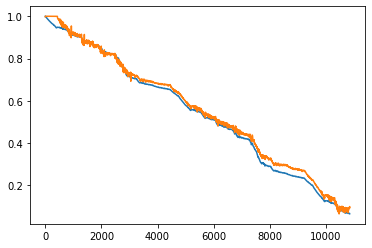

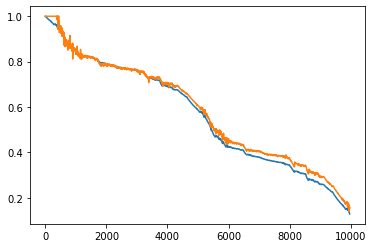

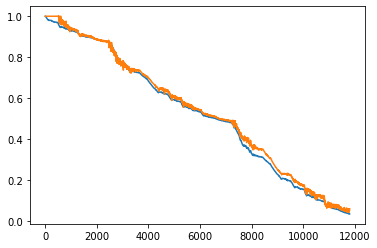

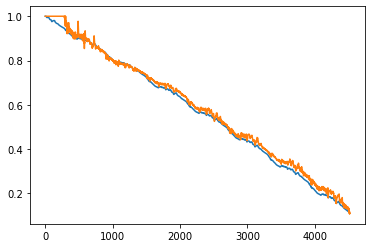

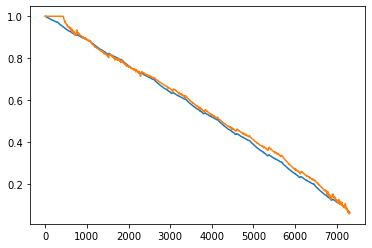

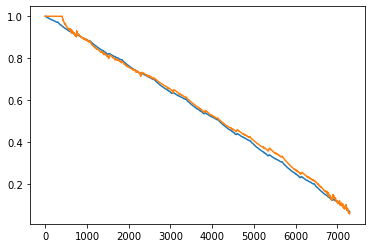

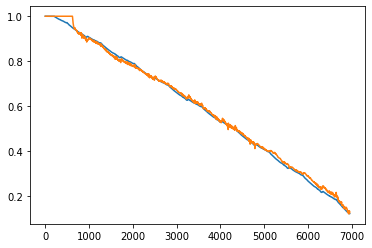

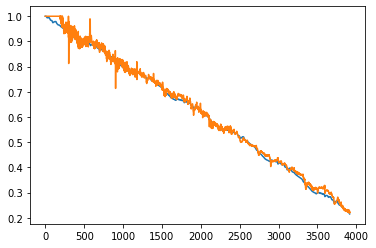

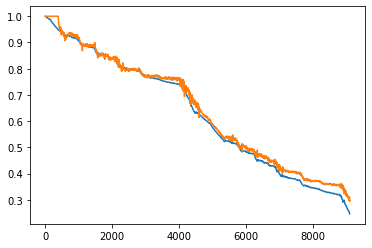

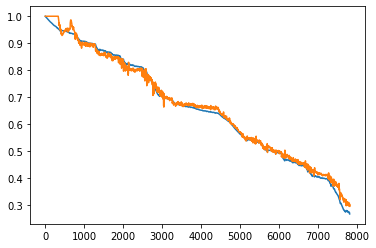

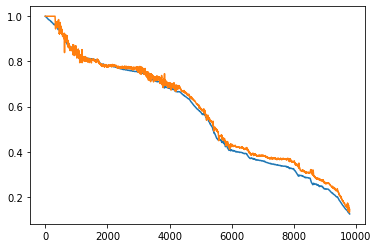

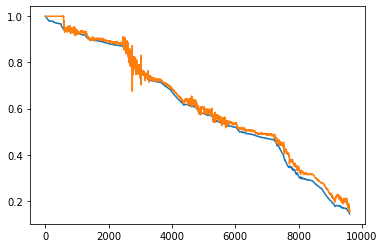

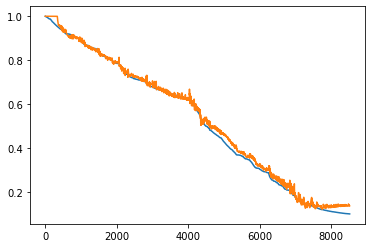

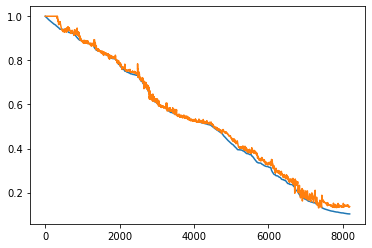

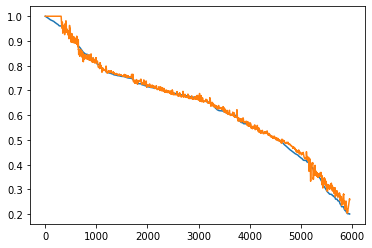

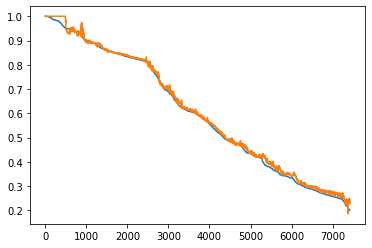

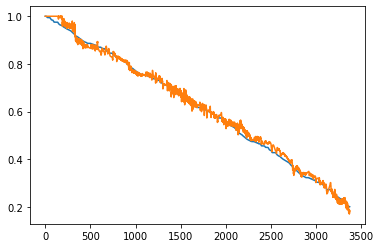

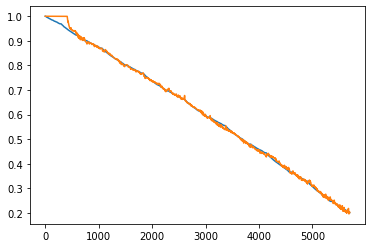

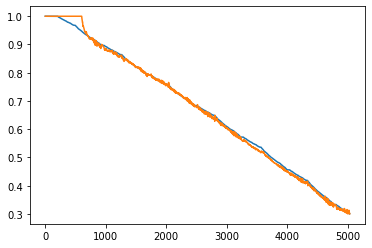

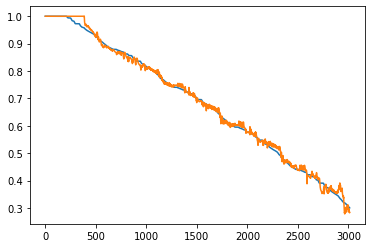

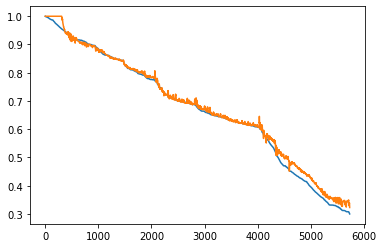

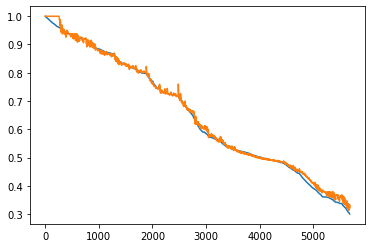

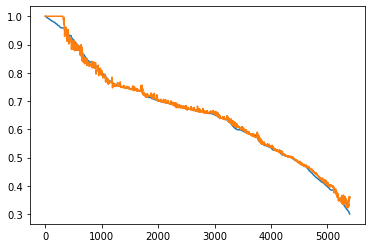

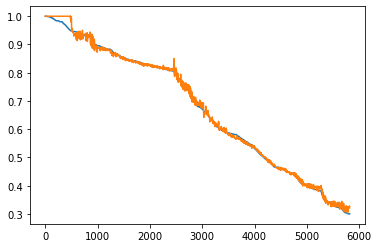

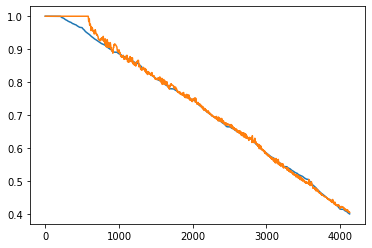

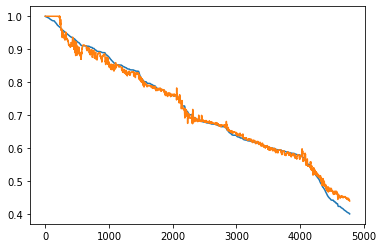

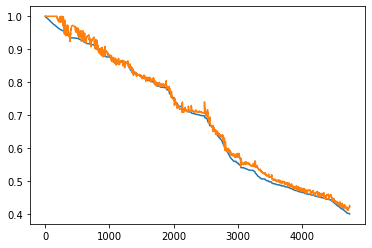

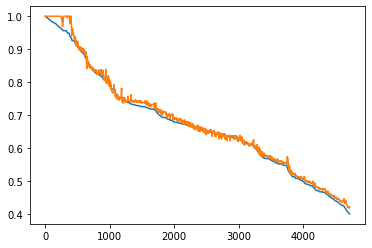

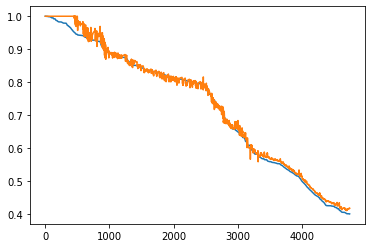

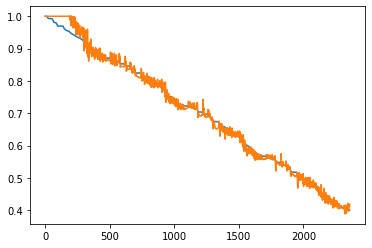

In [ ]:
y = []
y_hat = []

for (inputsnp, targetsnp) in all_chunks:
    with torch.no_grad():
        inputs = torch.from_numpy((inputsnp - means) / stds).float().unsqueeze(0).cuda()
        targets = torch.from_numpy(targetsnp).float().unsqueeze(0).cuda()
        outputs = model(inputs).cpu().numpy()[0]
        plt.plot(targetsnp[:, 0])
        plt.plot(outputs[:, 0])
        y.append(targetsnp[:, 0])
        y_hat.append(outputs[:, 0])
        plt.show()


In [ ]:
import math
total_rmse_test = 0
for x_idx, i in enumerate(y):
  mse_test = 0
  for y_idx, j in enumerate(i):
    mse_test += ((y_hat[x_idx][y_idx] - j)**2)
  mse_test /= i.shape[0]
  total_rmse_test += mse_test
  rmse_test = math.sqrt(mse_test)
  print("Plot", x_idx, "RMSE = ", rmse_test)
total_rmse_test /= len(y)
total_rmse_test = math.sqrt(total_rmse_test)
print("Total RMSE: ", total_rmse_test)

Plot 0 RMSE =  0.022166897093506728
Plot 1 RMSE =  0.021755480215089426
Plot 2 RMSE =  0.019330170859224515
Plot 3 RMSE =  0.020010029142586542
Plot 4 RMSE =  0.017482035226286333
Plot 5 RMSE =  0.014972221540593902
Plot 6 RMSE =  0.012212987270235589
Plot 7 RMSE =  0.01363626091312586
Plot 8 RMSE =  0.020411818577453777
Plot 9 RMSE =  0.014948147184501222
Plot 10 RMSE =  0.02072011616779066
Plot 11 RMSE =  0.020733835100420175
Plot 12 RMSE =  0.017998571987196208
Plot 13 RMSE =  0.018256696810420168
Plot 14 RMSE =  0.013456528044099685
Plot 15 RMSE =  0.013011054333406272
Plot 16 RMSE =  0.01532671937840275
Plot 17 RMSE =  0.009562903613673499
Plot 18 RMSE =  0.011160604752246823
Plot 19 RMSE =  0.012545461683562728
Plot 20 RMSE =  0.016446598941551017
Plot 21 RMSE =  0.010954743185697696
Plot 22 RMSE =  0.010643769364568135
Plot 23 RMSE =  0.009963792768370502
Plot 24 RMSE =  0.0113199297142882
Plot 25 RMSE =  0.013917846999047164
Plot 26 RMSE =  0.01366999695360165
Plot 27 RMSE =  0

Test Model

In [ ]:
#val_chunks = extract_mat_file_chunks(["n10degC_LA92_Pan18650PF.mat"])

In [ ]:
#for (inputsnp, targetsnp) in val_chunks:
  #  with torch.no_grad():
   #     inputs = torch.from_numpy((inputsnp - means) / stds).float().unsqueeze(0).cuda()
   #     targets = torch.from_numpy(targetsnp).float().unsqueeze(0).cuda()
    #    outputs = model(inputs).cpu().numpy()[0]
    #    plt.plot(targetsnp[:, 0])
    #    plt.plot(outputs[:, 0])
    #    plt.show()